In [ ]:

# Install required packages
!pip install --upgrade scikit-learn==1.4.0 -q
!pip install --upgrade category_encoders -q
!pip install lightgbm -q
!pip install xgboost -q
!pip install catboost -q
!pip install optuna -q
!pip install shap -q

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/adverts.csv')

# 1. Data Processing for Machine Learning

In [ ]:
data.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


In [ ]:
data.describe().astype(int)

,public_reference,mileage,year_of_registration,price
count,402005,401878,368694,402005
mean,202007077472444,37743,2015,17341
std,16916615997,34831,7,46437
min,201307177852187,0,999,120
25%,202009023197699,10481,2013,7495
50%,202009304400624,28629,2016,12600
75%,202010175124399,56875,2018,20000
max,202011025683478,999999,2020,9999999


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [ ]:
data.isnull().sum()


public_reference             0
mileage                    127
reg_code                 31857
standard_colour           5378
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     33311
price                        0
body_type                  837
crossover_car_and_van        0
fuel_type                  601
dtype: int64

In [ ]:
data.shape

(402005, 12)

In [ ]:
dataSubset = data.sample(30000)


In [ ]:
# Drop irrelevant columns
dataSubset = dataSubset.drop(columns=['public_reference', 'reg_code', 'crossover_car_and_van'])
dataSubset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 2266 to 129299
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mileage               29996 non-null  float64
 1   standard_colour       29606 non-null  object 
 2   standard_make         30000 non-null  object 
 3   standard_model        30000 non-null  object 
 4   vehicle_condition     30000 non-null  object 
 5   year_of_registration  27533 non-null  float64
 6   price                 30000 non-null  int64  
 7   body_type             29926 non-null  object 
 8   fuel_type             29945 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.3+ MB


In [ ]:
# Handling missing values
sel_features = ['mileage', 'year_of_registration']
imputer = SimpleImputer(strategy='median')
dataSubset[sel_features] = imputer.fit_transform(dataSubset[sel_features])


In [ ]:
categorical_features = ['body_type', 'fuel_type', 'standard_colour']
imputer = SimpleImputer(strategy='most_frequent')
dataSubset[categorical_features] = imputer.fit_transform(dataSubset[categorical_features])

In [ ]:
dataSubset.isnull().sum()

mileage                 0
standard_colour         0
standard_make           0
standard_model          0
vehicle_condition       0
year_of_registration    0
price                   0
body_type               0
fuel_type               0
dtype: int64

In [ ]:
# Remove outliers
from scipy import stats
z_scores = np.abs(stats.zscore(dataSubset.select_dtypes(include=['float64', 'int64'])))
outliers = (z_scores > 3).any(axis=1)
dataSubsetWithoutOutliers = dataSubset[~outliers]


In [ ]:
print("Data with Outliers", dataSubset.shape)
print("Data without Outliers", dataSubsetWithoutOutliers.shape)

Data with Outliers (30000, 9)
Data without Outliers (29225, 9)


In [ ]:
# Drop duplicates and missing values
updatedData = dataSubsetWithoutOutliers.dropna().drop_duplicates(keep='first')
updatedData.shape

(29095, 9)

In [ ]:
# Remove rows with unusual years
unusual_years = [1007., 1515., 1063., 1009., 1016., 1010., 1008., 1018., 999., 1017., 1006., 1015.]
updatedData = updatedData[~updatedData['year_of_registration'].isin(unusual_years)]


Correlation between price and mileage: -0.47697685759557606


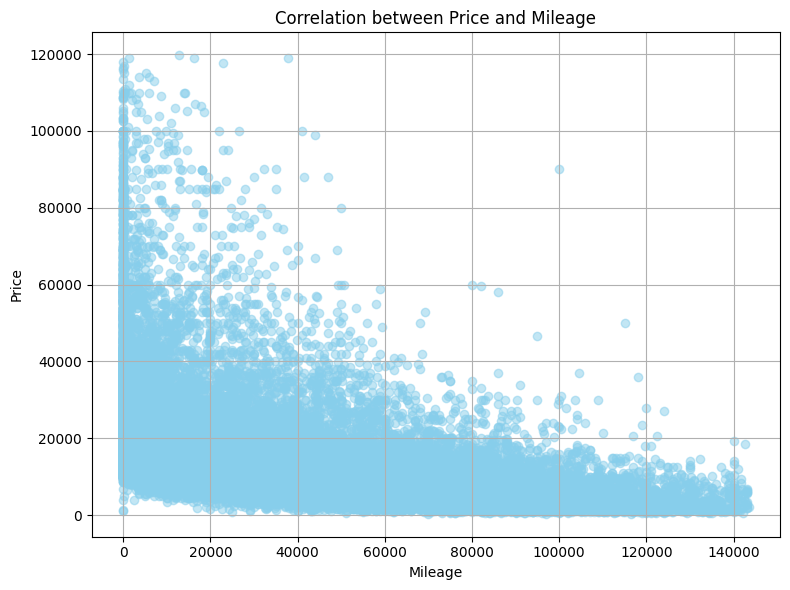

In [ ]:
# Calculate the correlation between price and mileage
correlation = updatedData['price'].corr(updatedData['mileage'])

print("Correlation between price and mileage:", correlation)

plt.figure(figsize=(8, 6))
plt.scatter(updatedData['mileage'], updatedData['price'], color='skyblue', alpha=0.5)
plt.title('Correlation between Price and Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: >

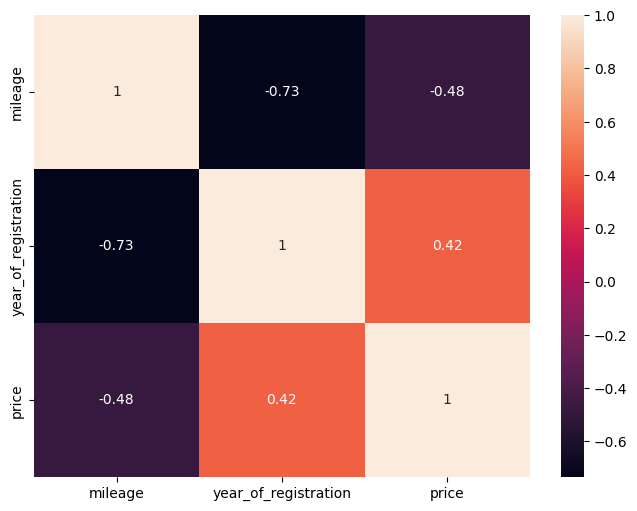

In [ ]:
heatMapCorr = updatedData.select_dtypes(include='number').corr()
plt.figure(figsize=(8,6))
sns.heatmap(heatMapCorr, annot=True)

# Feature Engineering

In [ ]:

# Feature Engineering
updatedData['age_of_vehicle'] = pd.Timestamp.now().year - updatedData['year_of_registration']
updatedData['mileage_per_year'] = updatedData['mileage'] / updatedData['age_of_vehicle']
updatedData['mileage_age_interaction'] = updatedData['mileage'] * updatedData['age_of_vehicle']
updatedData.head()


,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,fuel_type,age_of_vehicle,mileage_per_year,mileage_age_interaction
2266,47.0,Orange,Dacia,Duster,USED,2020.0,14000,SUV,Bi Fuel,4.0,11.750000,188.0
298467,24864.0,Black,BMW,X6,USED,2016.0,34495,SUV,Diesel,8.0,3108.000000,198912.0
342478,5.0,Blue,BMW,1 Series,NEW,2016.0,39130,Hatchback,Petrol,8.0,0.625000,40.0
229359,75000.0,Red,Alfa Romeo,MiTo,USED,2014.0,4095,Hatchback,Diesel,10.0,7500.000000,750000.0
389780,44300.0,Black,Audi,A6 Avant,USED,2018.0,17750,Estate,Diesel,6.0,7383.333333,265800.0


In [ ]:
updatedData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29095 entries, 2266 to 129299
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mileage                  29095 non-null  float64
 1   standard_colour          29095 non-null  object 
 2   standard_make            29095 non-null  object 
 3   standard_model           29095 non-null  object 
 4   vehicle_condition        29095 non-null  object 
 5   year_of_registration     29095 non-null  float64
 6   price                    29095 non-null  int64  
 7   body_type                29095 non-null  object 
 8   fuel_type                29095 non-null  object 
 9   age_of_vehicle           29095 non-null  float64
 10  mileage_per_year         29095 non-null  float64
 11  mileage_age_interaction  29095 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.9+ MB


In [ ]:

# Encoding categorical features
cols = ['standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'body_type', 'fuel_type']


In [ ]:
encoder = OrdinalEncoder()
updatedData[cols] = encoder.fit_transform(updatedData[cols])
updatedData.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,fuel_type,age_of_vehicle,mileage_per_year,mileage_age_interaction
2266,47.0,12.0,13.0,234.0,1.0,2020.0,14000,11.0,0.0,4.0,11.750000,188.0
298467,24864.0,1.0,5.0,614.0,1.0,2016.0,34495,11.0,1.0,8.0,3108.000000,198912.0
342478,5.0,2.0,5.0,0.0,0.0,2016.0,39130,5.0,5.0,8.0,0.625000,40.0
229359,75000.0,15.0,1.0,379.0,1.0,2014.0,4095,5.0,1.0,10.0,7500.000000,750000.0
389780,44300.0,1.0,4.0,86.0,1.0,2018.0,17750,4.0,1.0,6.0,7383.333333,265800.0


In [ ]:
updatedData.shape

(29095, 12)

In [ ]:
# Creating X and y
X, y = updatedData.drop(columns='price'), updatedData['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Create Preprocessing Pipeline
def preProcessingPipeline():
    # Identify numeric and categorical features
    numeric_features = X.select_dtypes(include=np.number).columns
    categorical_features = X.select_dtypes(include='object').columns

    # Define preprocessing steps for numeric features
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())
    ])

    # Define preprocessing steps for categorical features
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])

    # Create preprocessor using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    return preprocessor


In [ ]:
# Feature Selection with RFE
def regression_pipeline(est):
    preprocessor = preProcessingPipeline()
    regr_pipe = Pipeline(steps=[("pp", preprocessor), ("rfe", RFE(est, n_features_to_select=8)), ("regr", est)])
    return regr_pipe



Feature Selection and Dimensionality Reduction

In [ ]:
updatedData.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,fuel_type,age_of_vehicle,mileage_per_year,mileage_age_interaction
2266,47.0,12.0,13.0,234.0,1.0,2020.0,14000,11.0,0.0,4.0,11.750000,188.0
298467,24864.0,1.0,5.0,614.0,1.0,2016.0,34495,11.0,1.0,8.0,3108.000000,198912.0
342478,5.0,2.0,5.0,0.0,0.0,2016.0,39130,5.0,5.0,8.0,0.625000,40.0
229359,75000.0,15.0,1.0,379.0,1.0,2014.0,4095,5.0,1.0,10.0,7500.000000,750000.0
389780,44300.0,1.0,4.0,86.0,1.0,2018.0,17750,4.0,1.0,6.0,7383.333333,265800.0


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=5).fit(X,y)
X_sel = selector.fit_transform(X,y)


In [ ]:
X_sel[:5, :]

array([[4.70000000e+01, 2.02000000e+03, 4.00000000e+00, 1.17500000e+01,
        1.88000000e+02],
       [2.48640000e+04, 2.01600000e+03, 8.00000000e+00, 3.10800000e+03,
        1.98912000e+05],
       [5.00000000e+00, 2.01600000e+03, 8.00000000e+00, 6.25000000e-01,
        4.00000000e+01],
       [7.50000000e+04, 2.01400000e+03, 1.00000000e+01, 7.50000000e+03,
        7.50000000e+05],
       [4.43000000e+04, 2.01800000e+03, 6.00000000e+00, 7.38333333e+03,
        2.65800000e+05]])

In [ ]:
selector.get_feature_names_out()

array(['mileage', 'year_of_registration', 'age_of_vehicle',
       'mileage_per_year', 'mileage_age_interaction'], dtype=object)

In [ ]:
feature_score = selector.scores_
feature_score.astype(int)

array([8568,  217,  720,  305, 4232, 6238, 1633,   10, 6238, 5827, 7379])

In [ ]:
feature_names = X.columns
feature_names

Index(['mileage', 'standard_colour', 'standard_make', 'standard_model',
       'vehicle_condition', 'year_of_registration', 'body_type', 'fuel_type',
       'age_of_vehicle', 'mileage_per_year', 'mileage_age_interaction'],
      dtype='object')

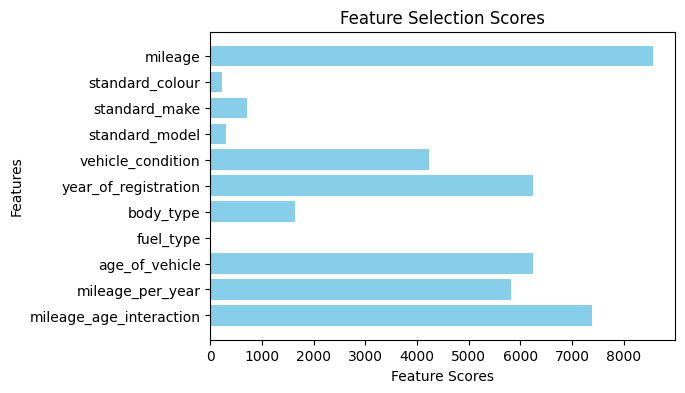

In [ ]:
plt.figure(figsize=(6,4))
plt.barh(feature_names, feature_score, color = 'skyblue')
plt.xlabel('Feature Scores')
plt.ylabel('Features')
plt.title('Feature Selection Scores')
plt.gca().invert_yaxis()
plt.show()

# Model Building

In [ ]:
# 4.1 A Linear Model

from sklearn.model_selection import cross_val_score
linear_model = regression_pipeline(LinearRegression())
linear_model.fit(X,y)
scores = cross_val_score(linear_model,X,y)
(scores.mean(), scores.std())

(0.36273859667494335, 0.013045518328812258)

In [ ]:
print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_train", X_test.shape, "y_train", y_test.shape)

X_train (23276, 11) y_train (23276,)
X_train (5819, 11) y_train (5819,)


In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#dimensionality reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [ ]:
Lregressor = LinearRegression()
Lregressor.fit(X_train_pca, y_train)

LinearRegression()

In [ ]:
y_pred = Lregressor.predict(X_test_pca)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absolute Error:", mae)
print("R^2 score:", r2)

Mean absolute Error: 7891.6081948071005
R^2 score: 0.2630766816669041


In [ ]:
y_pred = Lregressor.predict(X_train_pca)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Mean Absolute Error:", mae)
print("R^2 score:", r2)

Mean Absolute Error: 7701.285662688308
R^2 score: 0.2757215133283504


In [ ]:
linearModel_Evaluation = cross_validate(linear_model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=1)

print(linearModel_Evaluation['test_score'].mean(), linearModel_Evaluation['test_score'].std())
print(linearModel_Evaluation['train_score'].mean(), linearModel_Evaluation['train_score'].std())

-6631.88014908439 31.431730978668075
-6628.223519684313 36.81335166849305


In [ ]:
y_pred_test_linear_model = linear_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test_linear_model)
r2 = r2_score(y_test, y_pred_test_linear_model)

print("Mean absolute Error:", mae)
print("R^2 score:", r2)

Mean absolute Error: 6906.958668012503
R^2 score: 0.3483827712960639


In [ ]:
#Predict on train data
y_pred_train_linear_model = linear_model.predict(X_train)
mae  = mean_absolute_error(y_train, y_pred_train_linear_model)
r2 = r2_score(y_train, y_pred_train_linear_model)
print("Mean absolute Error:", mae)
print("R^2 score:", r2)

Mean absolute Error: 6654.959109520384
R^2 score: 0.3671187361827747


In [ ]:
#Linear model Performance
lr_result = pd.DataFrame({"y_true":y_test, "y_pred":y_pred_test_linear_model})
lr_result

,y_true,y_pred
337173,24590,35354.247488
253568,10440,14287.102974
92270,11395,13563.884483
233843,10598,17216.627392
186711,6495,10427.990201
...,...,...
280702,22047,17429.667528
92770,4250,10854.398595
172226,34990,15253.343492
244469,13404,22346.315731


<ipython-input-143-ee4de68d6072>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')


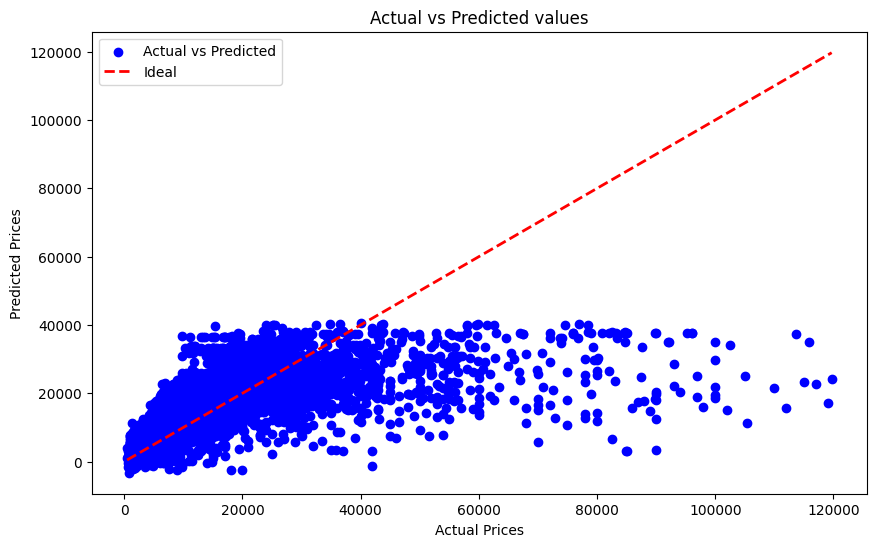

In [ ]:
# Plotting actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test_linear_model, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

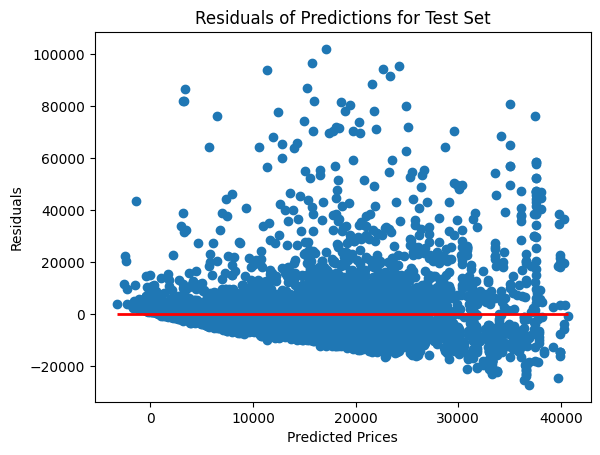

In [ ]:
#Residual Plot
residuals = y_test - y_pred_test_linear_model
plt.scatter(y_pred_test_linear_model, residuals)
plt.hlines(y=0, xmin=y_pred_test_linear_model.min(), xmax=y_pred_test_linear_model.max(), colors='red', lw =2 )
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residuals of Predictions for Test Set")
plt.show()

In [ ]:
# 4.2 A Random Forest
random_forest = regression_pipeline(RandomForestRegressor(n_estimators=100, random_state=42))
random_forest.fit(X_train, y_train)


Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['mileage', 'standard_colour', 'standard_make', 'standard_model',
       'vehicle_condition', 'year_of_registration', 'body_type', 'fuel_type',
       'age_of_vehicle', 'mileage_per_year', 'mileage_age_interaction'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object'))])),
                ('rfe',
                 RFE(estimator=RandomForestRegressor(random_state=42),
                     n_features_to_select=8)),
                ('regr', RandomForestRegressor(random_state=42))])

In [ ]:
randomForest_Evaluation = cross_validate(random_forest, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=1)

print(randomForest_Evaluation['test_score'].mean(), randomForest_Evaluation['test_score'].std())
print(randomForest_Evaluation['train_score'].mean(), randomForest_Evaluation['train_score'].std())

-2659.5693613006383 13.040929790997843
-1051.792011840979 3.3982187048081465


In [ ]:
y_pred_test_RF_model = random_forest.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test_RF_model)
r2 = r2_score(y_test, y_pred_test_RF_model)

print("Mean Square Error:", mae)
print("R^2 score:", r2)

Mean Square Error: 2592.1675088570832
R^2 score: 0.8661723726083141


In [ ]:
#Predict on train data
y_pred_train_RF_model = random_forest.predict(X_train)
mae  = mean_absolute_error(y_train, y_pred_train_RF_model)
r2 = r2_score(y_train, y_pred_train_RF_model)
print("Mean Square Error:", mae)
print("R^2 score:", r2)

Mean Square Error: 993.063111498877
R^2 score: 0.9788065512723672


In [ ]:
#Random forest Performance
RF_result = pd.DataFrame({"y_true":y_test, "y_pred":y_pred_test_RF_model})
RF_result

,y_true,y_pred
337173,24590,23978.752728
253568,10440,10886.090000
92270,11395,10030.010000
233843,10598,10910.580000
186711,6495,5982.150000
...,...,...
280702,22047,21081.640000
92770,4250,6628.690000
172226,34990,18157.720000
244469,13404,24654.680000


<ipython-input-150-84ededbe291d>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')


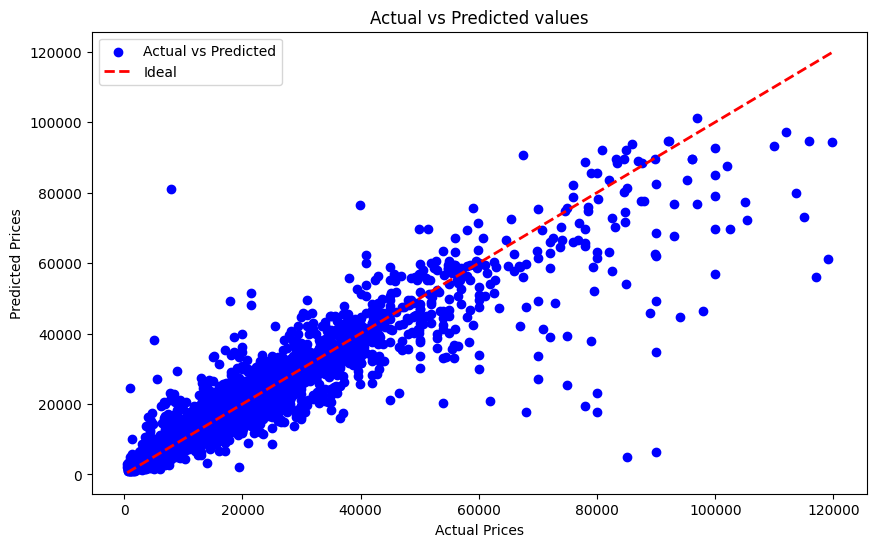

In [ ]:
# Plotting actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test_RF_model, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

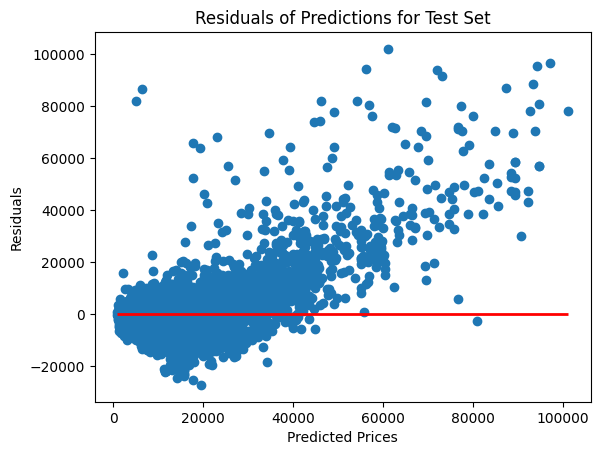

In [ ]:
#Residual Plot
residuals = y_test - y_pred_test_linear_model
plt.scatter(y_pred_test_RF_model, residuals)
plt.hlines(y=0, xmin=y_pred_test_RF_model.min(), xmax=y_pred_test_RF_model.max(), colors='red', lw =2 )
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residuals of Predictions for Test Set")
plt.show()

In [ ]:
# 4.3 A Boosted Tree
boosted_tree = regression_pipeline(GradientBoostingRegressor())
boosted_tree.fit(X_train, y_train)


Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['mileage', 'standard_colour', 'standard_make', 'standard_model',
       'vehicle_condition', 'year_of_registration', 'body_type', 'fuel_type',
       'age_of_vehicle', 'mileage_per_year', 'mileage_age_interaction'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object'))])),
                ('rfe',
                 RFE(estimator=GradientBoostingRegressor(),
                     n_features_to_select=8)),
                ('regr', GradientBoostingRegressor())])

In [ ]:
boosted_tree_Evaluation = cross_validate(boosted_tree, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=1)

print(boosted_tree_Evaluation['test_score'].mean(), boosted_tree_Evaluation['test_score'].std())
print(boosted_tree_Evaluation['train_score'].mean(), boosted_tree_Evaluation['train_score'].std())

-3868.3702832521935 40.741454439655776
-3784.2642353070078 18.89320077151294


In [ ]:
y_pred_test_GB_model = boosted_tree.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test_GB_model)
r2 = r2_score(y_test, y_pred_test_GB_model)

print("Mean absolute Error:", mae)
print("R^2 score:", r2)

Mean absolute Error: 4085.1835048652442
R^2 score: 0.7403990721866454


In [ ]:
#Predict on train data
y_pred_train_GB_model = boosted_tree.predict(X_train)
mae  = mean_absolute_error(y_train, y_pred_train_GB_model)
r2 = r2_score(y_train, y_pred_train_GB_model)
print("Mean Square Error:", mae)
print("R^2 score:", r2)

Mean Square Error: 3829.731856808492
R^2 score: 0.7588912531095748


In [ ]:
#Gradient Boost Performance
GB_result = pd.DataFrame({"y_true":y_test, "y_pred":y_pred_test_GB_model})
GB_result

,y_true,y_pred
337173,24590,34251.443541
253568,10440,9048.753153
92270,11395,12512.780948
233843,10598,12625.631992
186711,6495,6429.447634
...,...,...
280702,22047,27388.754061
92770,4250,6199.624285
172226,34990,26244.359862
244469,13404,25124.439318


<ipython-input-157-7d7ed778bf22>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')


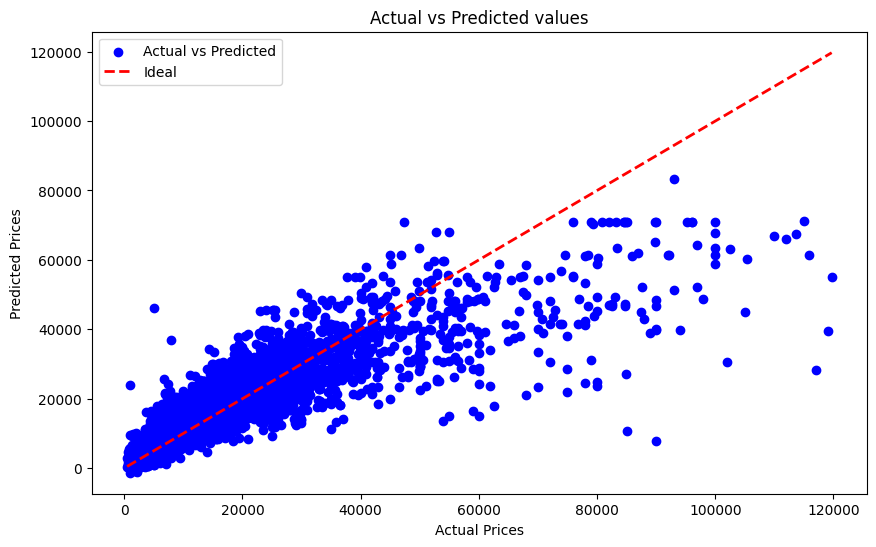

In [ ]:
# Plotting actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_test_GB_model, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

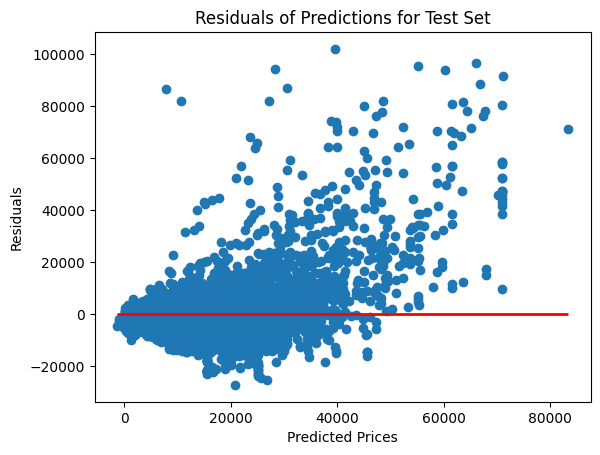

In [ ]:
#Residual Plot
residuals = y_test - y_pred_test_linear_model
plt.scatter(y_pred_test_GB_model, residuals)
plt.hlines(y=0, xmin=y_pred_test_GB_model.min(), xmax=y_pred_test_GB_model.max(), colors='red', lw =2 )
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residuals of Predictions for Test Set")
plt.show()

In [ ]:


# Define the hyperparameters grid for Gradient Boosting
gb_param_grid = {
    'regr__n_estimators': [50, 100],  # Prefix with 'regr__'
    'regr__learning_rate': [0.01, 0.1],
    'regr__max_depth': [3, 5]
}

# Define the hyperparameters grid for Random Forest
rf_param_grid = {
    'regr__n_estimators': [50, 100],  # Prefix with 'regr__'
    'regr__max_depth': [3, 5]
}


# Initialize the models
gb_model = regression_pipeline(GradientBoostingRegressor(random_state=42))
rf_model = regression_pipeline(RandomForestRegressor(random_state=42))



In [ ]:
from sklearn.model_selection import GridSearchCV
# Initialize GridSearchCV for Gradient Boosting
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Initialize GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform GridSearchCV for Gradient Boosting
gb_grid_search.fit(X_train, y_train)

# Perform GridSearchCV for Random Forest
rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['mileage', 'standard_colour', 'standard_make', 'standard_model',
       'vehicle_condition', 'year_of_registration', 'body_type', 'fuel_type',
       'age_of_vehicle', 'mileage_per_...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         Index([], dtype='object'))])),
                                       ('rfe',
                                        RFE(estimator=RandomForestRegressor(random_state=42),
                                            n_features_to_select=8)),
                                       ('regr',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regr__max_depth': [3, 5],
                         'regr__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
# Get the best hyperparameters for Gradient Boosting and Random Forest
best_gb_params = gb_grid_search.best_params_
best_rf_params = rf_grid_search.best_params_

print("Best Hyperparameters for Gradient Boosting:", best_gb_params)
print("Best Hyperparameters for Random Forest:", best_rf_params)

# Get the best models for Gradient Boosting and Random Forest
best_gb_model = gb_grid_search.best_estimator_
best_rf_model = rf_grid_search.best_estimator_

# Evaluate the best models on the test set
gb_preds = best_gb_model.predict(X_test)
rf_preds = best_rf_model.predict(X_test)

# Calculate the mean squared error (MSE) on the test set for Gradient Boosting and Random Forest
gb_mse = mean_squared_error(y_test, gb_preds)
rf_mse = mean_squared_error(y_test, rf_preds)

print("Mean Squared Error (MSE) on Test Set for Gradient Boosting:", gb_mse)
print("Mean Squared Error (MSE) on Test Set for Random Forest:", rf_mse)


Best Hyperparameters for Gradient Boosting: {'regr__learning_rate': 0.1, 'regr__max_depth': 5, 'regr__n_estimators': 100}
Best Hyperparameters for Random Forest: {'regr__max_depth': 5, 'regr__n_estimators': 100}
Mean Squared Error (MSE) on Test Set for Gradient Boosting: 32493593.242973603
Mean Squared Error (MSE) on Test Set for Random Forest: 84784346.00909019


In [ ]:




# Ensemble
ensemble_models = [linear_model, best_rf_model, best_gb_model]

# Average voter
class AverageVoter:
    def predict(self, X):
        return sum(model.predict(X) for model in ensemble_models) / len(ensemble_models)

# Create an instance of the AverageVoter class
ensemble_model = AverageVoter()

# No need to fit the ensemble_model since it doesn't require training
# One can directly use ensemble_model to make predictions
ensemble_predictions = ensemble_model.predict(X_test)

from sklearn.ensemble import VotingRegressor
ensemble = VotingRegressor(
    [
        ("lr", linear_model),
        ("rf", best_rf_model),
        ('gb', best_gb_model)
    ]
)
ensemble.fit(X_train, y_train)



VotingRegressor(estimators=[('lr',
                             Pipeline(steps=[('pp',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['mileage', 'standard_colour', 'standard_make', 'standard_model',
       'vehicle_condition', 'year_of_registration', 'body_type', 'fuel_type',
       'age_of_vehicle', 'mileag...
       'age_of_vehicle', 'mileage_per_year', 'mileage_age_interaction'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OrdinalEncoder())]),
                                                                               Index([], dtype='object'))])),
                                             ('rfe',
                                              RFE(estimator=GradientBoostingRegressor(random_state=42),
                                                  n_features_to_select=8)),
                                             ('regr',
                                              GradientBoostingRegressor(max_depth=5,
                                                                        random_state=42))]))])

In [163]:
eval_result = cross_validate(ensemble, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', return_train_score=True)

ensemble_result = (
    -eval_result['test_score'].mean(), eval_result['test_score'].std(),
    -eval_result['train_score'].mean(), eval_result['train_score'].std()
    )

print(ensemble_result)

(4429.547005222611, 45.451314244083235, 4331.649389529147, 13.279376245069715)


In [164]:
ensemble_y_pred = ensemble.predict(X_test)
ensemble_mse = mean_absolute_error(y_test, ensemble_y_pred)
ensemble_rsquare = r2_score(y_test, ensemble_y_pred)

print("Mean absolute Error:", ensemble_mse)
print("R^2 score:", ensemble_rsquare)

Mean absolute Error: 4610.948778742905
R^2 score: 0.6846036391871028


In [165]:
#Predict on train data
y_pred_train_ensemble_model = ensemble.predict(X_train)
mse  = mean_absolute_error(y_train, y_pred_train_ensemble_model)
r2 = r2_score(y_train, y_pred_train_ensemble_model)
print("Mean Square Error:", mse)
print("R^2 score:", r2)

Mean Square Error: 4337.975606596861
R^2 score: 0.713689429117718


In [166]:
#Ensemble Performance
GB_result = pd.DataFrame({"y_true":y_test, "y_pred":y_pred_test_GB_model})
GB_result

,y_true,y_pred
337173,24590,34251.443541
253568,10440,9048.753153
92270,11395,12512.780948
233843,10598,12625.631992
186711,6495,6429.447634
...,...,...
280702,22047,27388.754061
92770,4250,6199.624285
172226,34990,26244.359862
244469,13404,25124.439318


<ipython-input-167-4663879ccc2b>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')


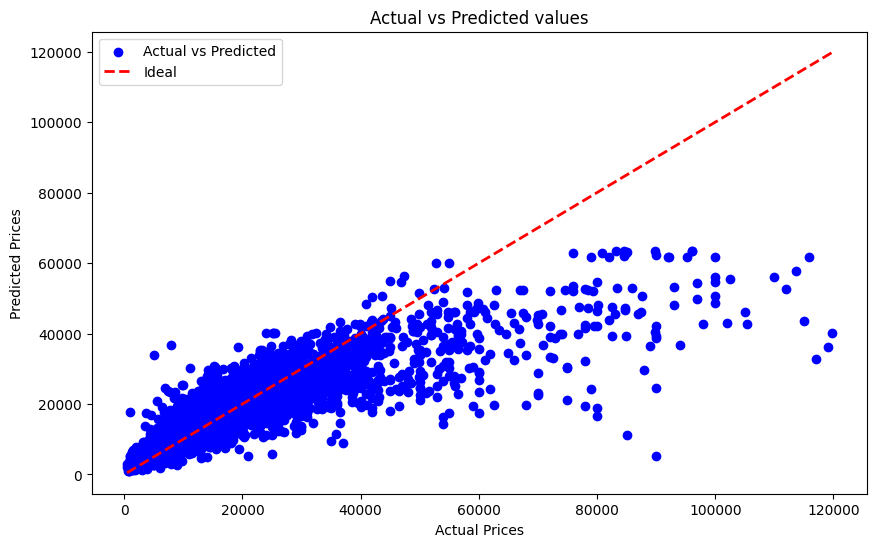

In [167]:
# Plotting actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, ensemble_y_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

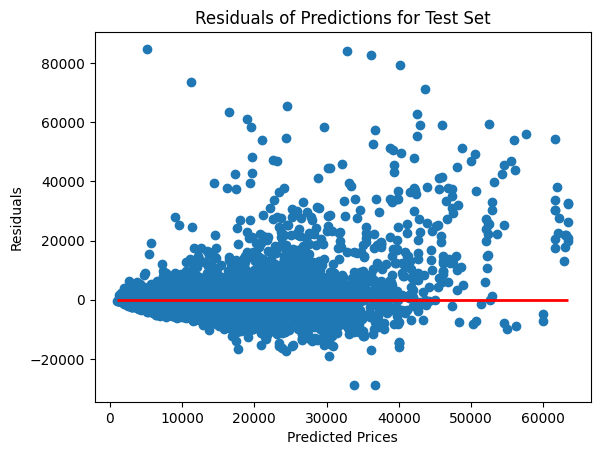

In [168]:
#Residual Plot
residuals = y_test - ensemble_y_pred
plt.scatter(ensemble_y_pred, residuals)
plt.hlines(y=0, xmin=ensemble_y_pred.min(), xmax=ensemble_y_pred.max(), colors='red', lw =2 )
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residuals of Predictions for Test Set")
plt.show()

In [169]:
subsetTrain = X.head(10)
subsetTest = y.head(10)
linear_model_prediction = linear_model.predict(subsetTrain)
random_forest_model_prediction = random_forest.predict(subsetTrain)
boosted_tree_prediction_model = boosted_tree.predict(subsetTrain)
ensemble_prediction_model = ensemble.predict(subsetTrain)


Text(0.5, 1.0, 'Regressor predictions and their average')

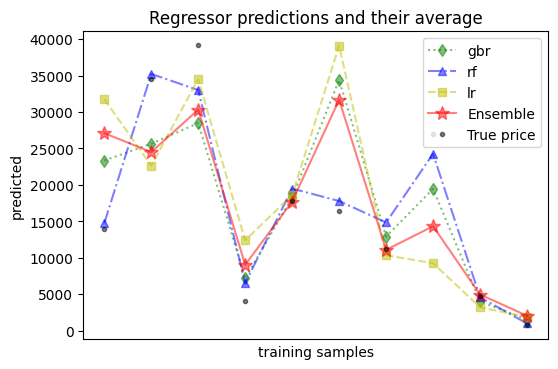

In [170]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(boosted_tree_prediction_model, "gd:", alpha=0.5, label ="gbr")
ax.plot(random_forest_model_prediction, "b^-.", alpha=0.5, label="rf")
ax.plot(linear_model_prediction, "ys--", alpha=0.5, label="lr")
ax.plot(ensemble_prediction_model, "r*-", alpha=0.5, ms=10, label="Ensemble")
# ax.plot(subsetTest, "ko", alpha=0.5, ms=3, label="True Data")

ax.plot(range(len(subsetTest)), subsetTest, "ko", alpha=0.5, ms=3, label="True price")


ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.set_ylabel("predicted")
ax.set_xlabel("training samples")
ax.legend(loc="best")
ax.set_title("Regressor predictions and their average")

 Model Evaluation and Analysis

In [171]:
# 5.1 Overall Performance with Cross-Validation
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate

# Define scorers
mean_squared_error_scorer = make_scorer(mean_squared_error)
mean_absolute_error_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Metrics dictionary
metrics = {
    'MSE': mean_squared_error_scorer,
    'MAE': mean_absolute_error_scorer,
    'R2 Score': r2_scorer
}

# Define models dictionary
models = {
    'Linear Regression': linear_model,
    'Random Forest': random_forest,
    'Boosted Tree': boosted_tree,
    'Ensemble': ensemble
}

# Initialize a results dictionary
cv_results = {}

# Perform cross-validation for each model and metric
for model_name, model in models.items():
    model_results = {}
    for metric_name, scorer in metrics.items():
        cv_scores = cross_validate(model, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1, return_train_score=True)
        model_results[metric_name] = {
            'test_mean': -cv_scores['test_score'].mean(),
            'test_std': cv_scores['test_score'].std(),
            'train_mean': -cv_scores['train_score'].mean(),
            'train_std': cv_scores['train_score'].std()
        }
    cv_results[model_name] = model_results

# Display the results
for model_name, results in cv_results.items():
    print(f"Results for {model_name}:")
    for metric_name, scores in results.items():
        print(f"  {metric_name}:")
        print(f"    Test Mean: {scores['test_mean']:.4f}")
        print(f"    Test Std: {scores['test_std']:.4f}")
        print(f"    Train Mean: {scores['train_mean']:.4f}")
        print(f"    Train Std: {scores['train_std']:.4f}")
    print("\n")


Results for Linear Regression:
  MSE:
    Test Mean: -121378836.9303
    Test Std: 2381875.6478
    Train Mean: -121283312.3544
    Train Std: 1196966.2398
  MAE:
    Test Mean: -6631.8801
    Test Std: 31.4317
    Train Mean: -6628.2236
    Train Std: 36.8133
  R2 Score:
    Test Mean: -0.3666
    Test Std: 0.0037
    Train Mean: -0.3672
    Train Std: 0.0018


Results for Random Forest:
  MSE:
    Test Mean: -28649393.3202
    Test Std: 1129244.1676
    Train Mean: -4556198.1023
    Train Std: 45662.9961
  MAE:
    Test Mean: -2659.5694
    Test Std: 13.0409
    Train Mean: -1051.7920
    Train Std: 3.3982
  R2 Score:
    Test Mean: -0.8503
    Test Std: 0.0086
    Train Mean: -0.9762
    Train Std: 0.0004


Results for Boosted Tree:
  MSE:
    Test Mean: -47238513.7272
    Test Std: 1656616.0562
    Train Mean: -44419311.5248
    Train Std: 971774.1621
  MAE:
    Test Mean: -3868.1918
    Test Std: 40.7202
    Train Mean: -3784.2642
    Train Std: 18.8932
  R2 Score:
    Test Mean: 

In [ ]:
# 5.2 True vs Predicted Analysis (5%)
y_pred_random_forest = random_forest.predict(X_test)

# Plotting actual vs predicted values
plt.scatter(y_test, y_pred_random_forest, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

In [ ]:
# Residuals Plot
residuals = y_test - y_pred_random_forest
plt.scatter(y_pred_random_forest, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_random_forest.min(), xmax=y_pred_random_forest.max(), colors='red', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions for Test Set')
plt.show()


In [ ]:
# 5.2 True vs Predicted Analysis (5%)
y_pred_gradient_booster = boosted_tree.predict(X_test)

# Plotting actual vs predicted values
plt.scatter(y_test, y_pred_gradient_booster, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

In [ ]:
# Residuals Plot
residuals = y_test - y_pred_gradient_booster
plt.scatter(y_pred_gradient_booster, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_gradient_booster.min(), xmax=y_pred_gradient_booster.max(), colors='red', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions for Test Set')
plt.show()


In [ ]:
# 5.2 True vs Predicted Analysis (5%)
# Compare true vs predicted values
y_pred_ensemble = ensemble_model.predict(X_test)

# Plotting actual vs predicted values
plt.scatter(y_test, y_pred_ensemble, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()


In [ ]:
# Residuals Plot
residuals = y_test - y_pred_ensemble
plt.scatter(y_pred_ensemble, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_ensemble.min(), xmax=y_pred_ensemble.max(), colors='red', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions for Test Set')
plt.show()


In [ ]:
gbr_shap = boosted_tree.named_steps['regr']

# gbr_shap = random_forest.named_steps['regr']

In [179]:
explainer_gbr_shap = shap.Explainer(gbr_shap, X_train)


In [180]:

shap_values = explainer_gbr_shap(X_test, check_additivity=False)

In [181]:
shap_values.shape, X_test.shape

((5819, 11), (5819, 11))

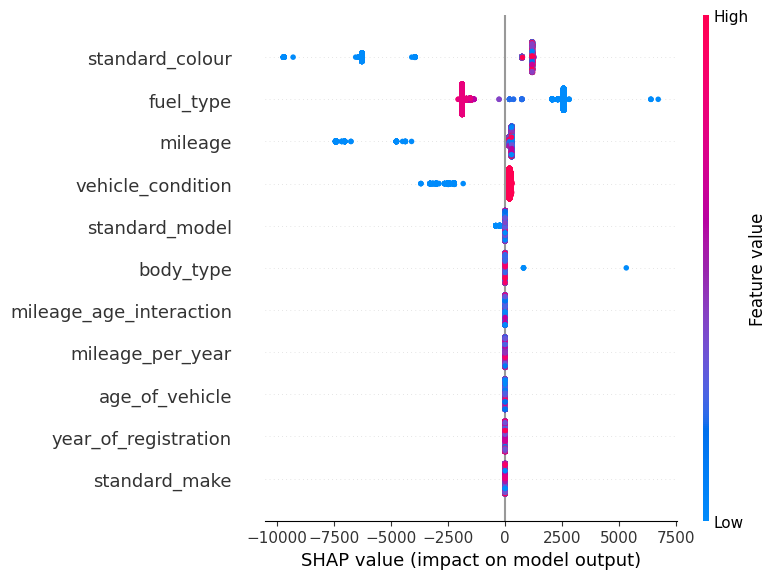

In [182]:
#Global Explanation:Feature Importance
plt.figure(figsize=(4,3))
shap.summary_plot(shap_values, X_test)

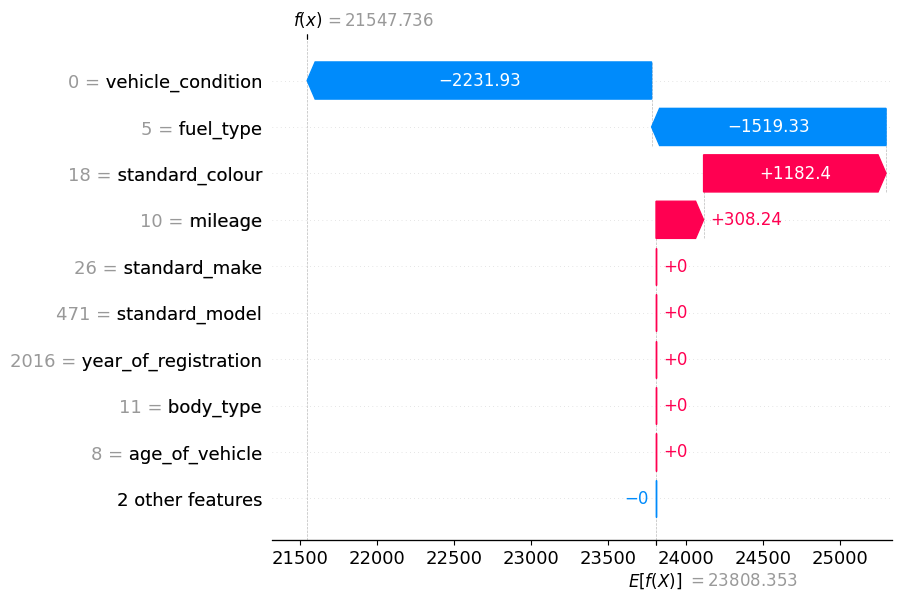

In [183]:
#local explanation
shap.plots.waterfall(shap_values[0])

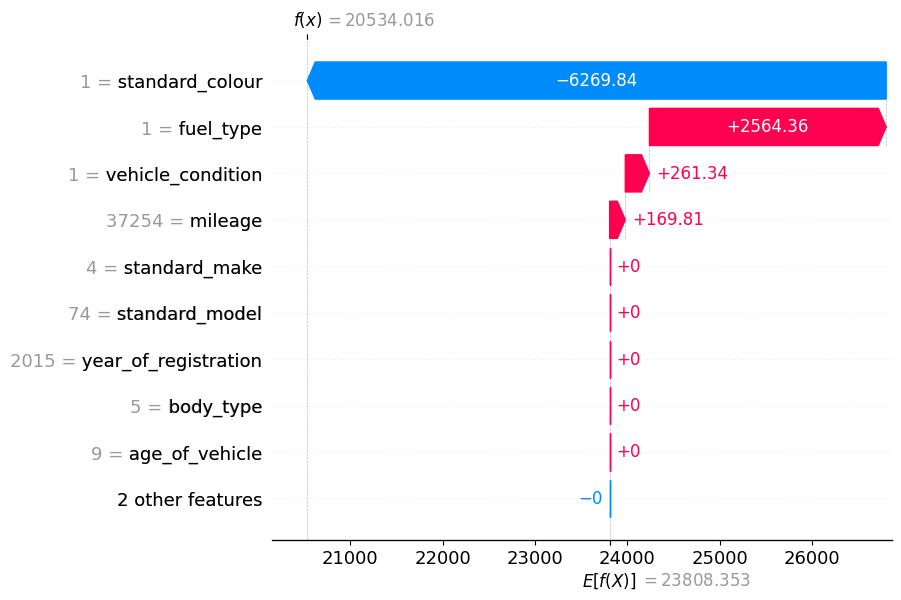

In [184]:
#local explanation
shap.plots.waterfall(shap_values[3])

In [185]:
from sklearn.inspection import PartialDependenceDisplay

<Figure size 600x400 with 0 Axes>

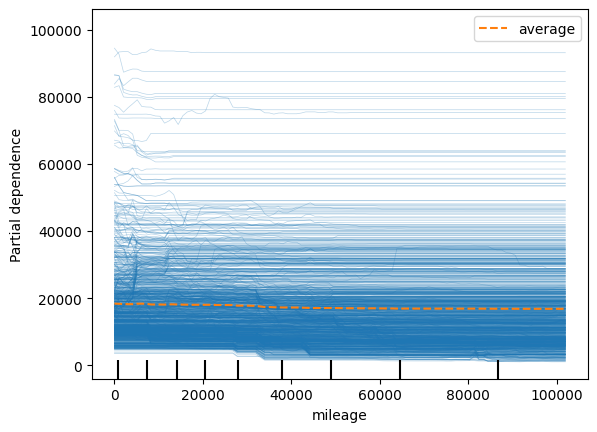

In [186]:
plt.figure(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    random_forest, X_test, features=['mileage'], kind='both'
);

In [ ]:
plt.figure(figsize=(4,3))
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.waterfall(shap_values[3])

In [ ]:
rf_shap = random_forest.named_steps['regr']
explainer_rf_shap = shap.TreeExplainer(rf_shap, X_train)
shap_values_rf = explainer_rf_shap(X_test, check_additivity = False)

In [ ]:
#Global Explanation:Feature Importance
plt.figure(figsize=(4,3))
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.plots.waterfall(shap_values_rf[3])

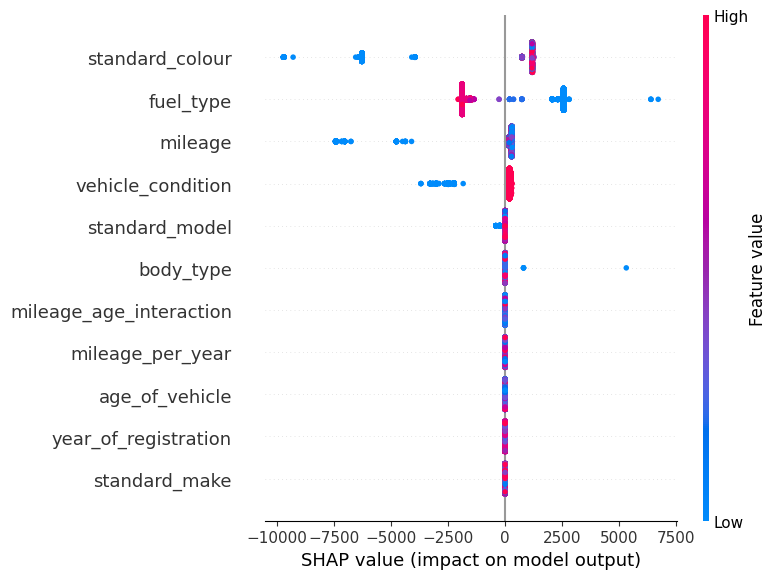

In [193]:
# Summary plot
shap.summary_plot(shap_values, X_test)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

# 5.4 Partial Dependency Plots (13%)
plt.figure(figsize=(6,4))
PartialDependenceDisplay.from_estimator(
    random_forest, X_test, features=['fuel_type'], kind='both'
)
plt.show()


In [ ]:
features = ['standard_colour', 'fuel_type', 'vehicle_condition', 'mileage', 'standard_model', 'body_type']

In [ ]:
PartialDependenceDisplay.from_estimator(random_forest,X_test, features)
fig, ax = plt.subplots(figsize=(6,4));

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
PartialDependenceDisplay.from_estimator(random_forest,X_test, ['standard_colour'])
plt.title('Partial Dependence of Standard Model on Price')
plt.xlabel('Standard colour')
plt.ylabel('Predicted Price')
plt.show()

In [ ]:
PartialDependenceDisplay.from_estimator(boosted_tree, X_train, X_train.columns)


In [ ]:
fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(boosted_tree, X_test, features = ['standar_color', 'fuel_type'], kind='both', ax=ax, n_cols=2)

In [ ]:
pdv_standard_model = partial_dependence(boosted_tree, X_test, features= ['standard_colour'], kind='both', grid_resolution=30)

pdv_age_of_vehicle = partial_dependence(boosted_tree, X_test, features= ['fuel_type'], kind='both', grid_resolution=30)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(6,4))

sns.lineplot(y = pdv_standard_model['individual'][0][0], x = pdv_standard_model['grid_values'][0], ax=axs[0] )
axs[0].set_xlabel('standard_colour')
axs[0].set_ylabel('Predicted Outcome')
axs[0].set_title('ICE Plot for fuel_type')

sns.lineplot(y = pdv_age_of_vehicle['individual'][0][0], x = pdv_age_of_vehicle['grid_values'][0], ax=axs[1] )
axs[0].set_xlabel('fuel_type')
axs[0].set_ylabel('Predicted Outcome')
axs[0].set_title('ICE Plot for fuel_type')

plt.tight_layout()
plt.show()

In [ ]:
# 5.4 Partial Dependency Plots (13%)
# Partial Dependency Plots
for feature in X_train.columns:
    shap.dependence_plot(feature, shap_values.values, X_test, feature_names=X_test.columns)
